In [1]:
using HDF5
using Plots
#using GR
using Statistics
using DelimitedFiles
using FFTW
using FourierAnalysis

function read_snap(filename :: String)
    
    pos  = h5read(filename,"PartType0/Coordinates")
#    Bfl  = h5read(filename,"PartType0/Bfield") 
    Vel  = h5read(filename,"PartType0/Velocities")
#    alp  = h5read(filename,"PartType0/EPalpha")
#    bet  = h5read(filename,"PartType0/EPbeta")
#    divB = h5read(filename,"PartType0/divB")
    #Ids  = h5read(filename,"PartType0/ParticleIDs")
    h    = h5read(filename,"PartType0/SmoothingLengths")
    rho  = h5read(filename,"PartType0/Densities")
    u    = h5read(filename,"PartType0/InternalEnergies")
    P    = h5read(filename,"PartType0/Pressures")
#    Ga   = h5read(filename,"PartType0/divB")
    head = h5readattr(filename,"Header")
    
    print("Leyendo ",filename," at time: ",head["Time"],"\n")
    x = pos[1,:]
    y = pos[2,:]
    z = pos[3,:]
#    bx = Bfl[1,:]
#    by = Bfl[2,:]
#    bz = Bfl[3,:]
    Vx = Vel[1,:]
    Vy = Vel[2,:]
    Vz = Vel[3,:]
    
    v2 = Vx.*Vx.+Vy.*Vy.+Vz.*Vz
#    b2 = by.*by.+by.*by.+bz.*bz
    
    Npart=size(rho,1)
    
#    NedivB=h .*  divB ./sqrt.(b2)
    #
#    print("Edivb mean: ",mean(abs.(NedivB)),"\n")
    print("Min x:",minimum(x)," / Max x:",maximum(x),"\n")
    print("Min y:",minimum(y)," / Max y:",maximum(y),"\n")
    print("Min z:",minimum(z)," / Max z:",maximum(z),"\n")
    print("Min h:",minimum(h)," / Max h:",maximum(h),"\n")
#    print("Min B2:",minimum(b2)," / Max B2:",maximum(b2),"\n")
#    (Dict(:H => head, :x=>pos, :bfl=> Bfl, :b2=>b2, :v=>Vel, :v2=>v2, 
#            :divB=>divB, :rho=>rho, :hsml=>h, #:bet=> bet, :alp=>alp, 
#            :Pres=> P, u=>u, :Npart=> Npart, :Gau=>Ga))
    (Dict(:H => head, :x=>pos, :v=>Vel, :v2=>v2, 
            :rho=>rho, :hsml=>h, #:bet=> bet, :alp=>alp, 
            :Pres=> P, u=>u, :Npart=> Npart))

end

function do_heat(data,what,Nmax)
    #Nmax=128
    #x=x.-minimum(x)
    #y=y.-minimum(y)
    #b2=data[what]
    b2=what
    Npart=size(b2,1)
    Lbox=1.0#+maximum(x)
    A = ones((Nmax, Nmax))*minimum(b2)
    grid = ones((Nmax, Nmax))
    #grid = [Set{Int}() for x=1:Nmax, y=1:Nmax];
    #insert(grid) = p -> push!(grid[trunc(Int, p.x/Lbox*Nmax), trunc(Int, p.y/Lbox*Nmax)], p.n);
    #foreach(insert(grid), data)
    x=data[:x][2,:]
    y=data[:x][1,:]
    for ind = 1:Npart
        i,j = trunc(Int, x[ind]/Lbox*Nmax+1), trunc(Int, y[ind]/Lbox*Nmax+1)
        A[i,j] += b2[ind]
        grid[i,j] += 1 
    end
    #AA=log10.(A./grid)
    AA=(A./grid)
    (AA)
end

function four_plt(file)
#file="OrszagTangVortex_0003.hdf5"
  if isfile(file) 
   run=read_snap(file)
   #run=read_snap("OT.NR.VP.00.hdf5")
   Nmax =200
   EdivB=run[:hsml].*run[:divB] ./ sqrt.(run[:b2])
   EdivB = log10.(abs.(EdivB))
   #EdivB = abs.(run[:Gau])
   #EdivB = run[:Pres]./(sqrt.(run[:b2]/(8*3.14)))
   bb=run[:bfl]
   gr()
   AA   =do_heat(run,(run[:rho]),Nmax)
   h1=heatmap(1:Nmax,1:Nmax,AA,color=cgrad([:blue,:green,:yellow,:red]),clim=(0.1,0.5),colorbar=:left)
   AA   =do_heat(run,(run[:Pres]),Nmax)
   h2=heatmap(1:Nmax,1:Nmax,AA,color=cgrad([:blue,:yellow,:purple]),clim=(0.01,0.7)) 
   AA   =do_heat(run,(run[:b2])./2,Nmax)
   h3=heatmap(1:Nmax,1:Nmax,AA,color=cgrad([:blue, :yellow ,:red]),clim=(0.01,0.25))
   AA   =do_heat(run,(EdivB),Nmax)
   #h4=heatmap(1:Nmax,1:Nmax,AA,color=cgrad([:blue,:white]),clim=(0.0,10.0))#,clim=(-4.0,-1.0))

   h4=heatmap(1:Nmax,1:Nmax,AA,color=cgrad([:blue,:white]),clim=(-10.0,-1.0))

   plot(h1,h2,h3,h4,layout=4,size=(1024,1024),aspect_ratio=:equal,colorbar_title=["\$Density\$" "\$Pressure\$" "\$B^2/2\$" "\$log10(err_{divB})\$"],colorbar=[:left :top :left :right])

    #savefig("Vort001.png")
  else
     println("File ",file," *** NOT FOUND ***")
    
     #savefig("Vort001.png")
   end
end

function mirror_plt(file)
    if isfile(file)
        run=read_snap(file)
        #run=read_snap("OT.NR.VP.00.hdf5")
        Nmax = 256
        Nmax2 = Nmax
        EdivB=run[:hsml].*run[:divB] ./ sqrt.(run[:b2])
        EdivB = log10.(abs.(EdivB))
        bb=run[:bfl]
        gr()
        AA   =do_heat(run,(run[:rho]),Nmax)
        #AA = AA'
        r0 = range(start=1,stop=Nmax,step=1)
        r1 = range(start=1,stop=Nmax,step=1)
        r2 = range(start=Nmax,stop=1,step=-1)
        r3 = range(start=Nmax,stop=1,step=-1)
        BB1  = AA[r0 ,r1] 
        BB2  = AA[r2, r3]
        BB = (BB1.-BB2)./(BB1.+BB2)
        BB = abs.(BB)
        println("Maximum ",maximum(BB))
        h1=heatmap(1:Nmax,1:Nmax2,BB,color=cgrad([:white,:blue,:red]),clim=(0.00001,0.05),aspect_ratio=:equal)
    else
        println("File ",file," *** NOT FOUND ***")
    end
end


function pltStat(file)
    if isfile(file)
        re=readdlm("stat_BASE.txt", skipstart=108)
        ri=readdlm(file, skipstart=108)
        eTim=re[:,2]
        eb2=re[:,35]
        edivB=re[:,36]
        eHmag=re[:,38]
        
        iTim=ri[:,2]
        ib2=ri[:,35]
        idivB=ri[:,36]
        iHmag=ri[:,38]
        
        lab=file[begin:end-15]
        
        h1=plot([eTim,iTim],[eb2,ib2],ylabel="b2",label=["Norm" lab])
        h2=plot([eTim,iTim],[edivB,idivB],ylabel="DivB",label=["Norm" lab],yaxis=:log)
        h3=plot([eTim,iTim],[eHmag,iHmag],ylabel="Hmag",label=["Norm" lab],ylim=(-0.5,0.5))
        h4=plot([eTim,iTim],[abs.(eHmag),abs.(iHmag)],ylab="|Hmag|",label=["Norm" lab])
        plot(h1,h2,h3,h4,layout=4, xlabel="Time" )
    else
        println("File ",file," *** NOT FOUND ***")
    end
end

function do_box(data,what,Nmax)
    #Nmax=128
    #x=x.-minimum(x)
    #y=y.-minimum(y)
    #b2=data[what]
    b2=what
    Npart=size(b2,1)
    Lbox=1.0#+maximum(x)
    A = ones((Nmax, Nmax, Nmax))*minimum(b2)
    grid = ones((Nmax, Nmax, Nmax))
    x=data[:x][1,:]
    y=data[:x][2,:]
    z=data[:x][3,:]
    
    for ind = 1:Npart
        i,j,k = trunc(Int, x[ind]/Lbox*Nmax+1), trunc(Int, y[ind]/Lbox*Nmax+1), trunc(Int, z[ind]/Lbox*Nmax+1)
        A[i,j,k] += b2[ind]
        grid[i,j,k] += 1 
    end
    #AA=log10.(A./grid)
    AA=(A./grid)
    (AA)
end


do_box (generic function with 1 method)

In [51]:
function PowSpec(Vx, Vy, Vz; hx=nothing, hy=nothing, hz=nothing, h=1.0)
#    '''Calcula el es espectro de potencias dado un campo
#        3D creado por 3 matrices Vx, Vy, Vz.
#    
#    Parámetros:
#    -----------
#    Vx   : Array N-D con valores correspondientes a 
#            la dirección X. (np.array [SIZE])
#    Vy   : Array N-D con valores correspondientes a 
#            la dirección Y. (np.array [SIZE])
#    Vz   : Array N-D con valores correspondientes a 
#            la dirección Z. (np.array [SIZE])
#    hx   : Ancho de celda (físico) en x.
#           [Opcional] (int/float; Default=1)
#    hy   : Ancho de celda (físico) en y.
#           [Opcional] (int/float; Default=1)
#    hz   : Ancho de celda (físico) en z.
#           [Opcional] (int/float; Default=1)
#    h    : Ancho de celda (físico) de cualquier dirección
#           no definida. 
#           [Opcional] (int/float; Default=1)
#=    Returns:
    --------
=#
    hx == nothing ? hx = h : nothing
    hy == nothing ? hy = h : nothing
    hz == nothing ? hz = h : nothing
    #Ngrids y dRs
    ngx = size(Vx,1)
    ngy = size(Vx,2)
    ngz = size(Vx,3)
    dx  = hx*ngx/2.
    dy  = hy*ngy/2.
    dz  = hz*ngz/2.
    #Transformamos las velocidades
    Vkx = FFTW.rfft(Vx)
    Vky = FFTW.rfft(Vy)
    Vkz = FFTW.rfft(Vz)
    Vkk2 = abs.(Vkx).^2 + abs.(Vky).^2 + abs.(Vkz).^2
    #Definimos las frecuencias
    Kx    = FFTW.fftfreq(ngx, hx)
    Ky    = FFTW.fftfreq(ngy, hy)
    Kz    = FFTW.rfftfreq(ngz, hz)
    kmin  = 1.0/dz
    println(length(Kx),length(Ky),length(Kz))
    println(size(Vkk2))
    E = zeros(length(Kz),2)
    E[:,1] = Kz.+kmin
    E[:,2] = reshape(mean(Vkk2,dims=(2,3)),length(Kz))
    
    return E
end

PowSpec2 (generic function with 1 method)

In [38]:
b=read_snap("turb-box_0000.hdf5")
c=read_snap("turb-box_0010.hdf5")

Leyendo turb-box_0000.hdf5 at time: [0.0]
Min x:0.0078125 / Max x:0.9921875
Min y:0.0078125 / Max y:0.9921875
Min z:0.0078125 / Max z:0.9921875
Min h:0.019268049 / Max h:0.019268075
Leyendo turb-box_0010.hdf5 at time: [0.9999999999999999]
Min x:1.3672670390544252e-5 / Max x:0.9999998578199034
Min y:9.413971133871319e-7 / Max y:0.9999997376998417
Min z:3.0203990533088856e-6 / Max z:0.9999920788053761
Min h:0.019082181 / Max h:0.0195169


Dict{Any, Any} with 9 entries:
  :Npart                    => 262144
  :Pres                     => Float32[0.999844, 0.987142, 0.988036, 1.00304, 0…
  Float32[1.50004, 1.49235… => Float32[1.50004, 1.49235, 1.49272, 1.50171, 1.49…
  :H                        => Dict{String, Any}("NumPart_Total_HighWord"=>UInt…
  :v                        => Float32[-0.0423798 0.0800113 … 0.03116 -0.025391…
  :rho                      => Float32[0.999815, 0.992203, 0.992855, 1.00189, 0…
  :v2                       => Float32[0.00342506, 0.00891035, 0.00246936, 0.00…
  :hsml                     => Float32[0.0192967, 0.0193426, 0.0193415, 0.01928…
  :x                        => [0.0378138 0.0149015 … 0.996534 0.94815; 0.99715…

In [39]:
a=c
Nmax=64
Ax=do_box(a,(a[:v][1,:]),Nmax)
Ay=do_box(a,(a[:v][2,:]),Nmax)
Az=do_box(a,(a[:v][3,:]),Nmax)

println("Minimum ",minimum(Ax), ", Maximum ", maximum(Ax))
println("Minimum ",minimum(Ay), ", Maximum ", maximum(Ay))
println("Minimum ",minimum(Az), ", Maximum ", maximum(Az))

#heatmap(1:Nmax,1:Nmax,AA[:,:,30],color=cgrad([:blue,:green,:yellow,:red]),colorbar=:left)
ps33=PowSpec(Ax,Ay,Az)
#ps23=PowSpec2(Ax,Ay,Az)

Minimum -0.16406257450580597, Maximum 0.01565052568912506
Minimum -0.17053984105587006, Maximum 0.00930157769471407
Minimum -0.158541738986969, Maximum 0.012233967892825603
646433
(64, 64, 33)


33×2 Matrix{Float64}:
 0.03125   101.406
 0.046875    0.189451
 0.0625      0.200359
 0.078125    0.194421
 0.09375     0.200116
 0.109375    0.205779
 0.125       0.208033
 0.140625    0.217289
 0.15625     0.220451
 0.171875    0.233096
 0.1875      0.238278
 0.203125    0.24393
 0.21875     0.244713
 ⋮         
 0.359375    0.285841
 0.375       0.295225
 0.390625    0.295686
 0.40625     0.300658
 0.421875    0.308235
 0.4375      0.311627
 0.453125    0.303551
 0.46875     0.312451
 0.484375    0.313896
 0.5         0.302269
 0.515625    0.306459
 0.53125     0.308923

In [54]:
k=l[:,1]
k4=0.0001.*k.^(-2.5/6)
#plot(k,k4,yaxis=:log, xaxis=:log,xlims=(10^(-1.3),1^(-0.8)))
#plot!(ps0a[:,1],ps0a[:,2])
#plot!(ps0b[:,1],ps0b[:,2])
#plot!(ps22[:,1],ps22[:,2])
#plot!(ps23[:,1],ps23[:,2])
#plot!(ps1a[:,1],ps1a[:,2])
#plot!(ps1b[:,1],ps1b[:,2])
#plot!(ps2a[:,1],ps2a[:,2])
#plot!(ps3a[:,1],ps3a[:,2])
#plot!(ps2b[:,1],ps2b[:,2])


33-element Vector{Float64}:
 0.00042378523774371814
 0.00035791052217759724
 0.00031748021039363993
 0.00028929270835048224
 0.0002681299341336612
 0.0002514495170480594
 0.0002378414230005442
 0.0002264508439419937
 0.0002167246561051747
 0.0002082866189854292
 0.00020087048891747152
 0.00019428171374524163
 0.00018837429543516564
 ⋮
 0.0001531751769895908
 0.0001504828375403633
 0.00014794489554378592
 0.0001455468333061126
 0.0001432759909098056
 0.0001411212699760837
 0.0001390728933447893
 0.00013712220858849925
 0.00013526152619755435
 0.00013348398541700344
 0.00013178344230871917
 0.00013015437580644602

In [ ]:
k=ps0a[:,1]
k4=k.^-2.0 .+10
plot(k,k4,yaxis=:log, xaxis=:log )

In [ ]:
d=read_snap("turb-box_0000.hdf5")
e=read_snap("turb-box_0010.hdf5")


In [ ]:
plot(r0, yaxis=:log, xaxis=:log)
plot!(r)

In [45]:
Nmax = 64
A = ones((Nmax, Nmax, Nmax))
# Set sampling rate (sr) and FFT window length (wl):
sr, wl = Nmax, Nmax

# Generate a sinusoidal wave at 10Hz with peak amplitude 0.5 and add some white noise:
v = sinusoidal(0.5, 10, sr, wl*wl*wl)

262144-element Vector{Float64}:
  0.0
  0.4157348061512726
  0.46193976625564337
  0.0975451610080643
 -0.35355339059327373
 -0.4903926402016152
 -0.1913417161825452
  0.2777851165098009
  0.5
  0.27778511650980114
 -0.19134171618254492
 -0.49039264020161527
 -0.35355339059327423
  ⋮
  0.35355339058623414
  0.4903926402015845
  0.19134171618650062
 -0.2777851165025501
 -0.5
 -0.27778511651233445
  0.19134171617562887
  0.4903926401992888
  0.35355339059455504
 -0.09754516100193325
 -0.4619397662515525
 -0.41573480615159325

In [46]:
vv=reshape(v,64,64,64)
#apa=fill(v,64,64)
#apb=reshape(apa,64*64*64)
#apb=reinterpret(Ax,apa)

64×64×64 Array{Float64, 3}:
[:, :, 1] =
  0.0        -1.22465e-15  -2.44929e-15  …  -9.0139e-14   2.94287e-14
  0.415735    0.415735      0.415735         0.415735     0.415735
  0.46194     0.46194       0.46194          0.46194      0.46194
  0.0975452   0.0975452     0.0975452        0.0975452    0.0975452
 -0.353553   -0.353553     -0.353553        -0.353553    -0.353553
 -0.490393   -0.490393     -0.490393     …  -0.490393    -0.490393
 -0.191342   -0.191342     -0.191342        -0.191342    -0.191342
  0.277785    0.277785      0.277785         0.277785     0.277785
  0.5         0.5           0.5              0.5          0.5
  0.277785    0.277785      0.277785         0.277785     0.277785
 -0.191342   -0.191342     -0.191342     …  -0.191342    -0.191342
 -0.490393   -0.490393     -0.490393        -0.490393    -0.490393
 -0.353553   -0.353553     -0.353553        -0.353553    -0.353553
  ⋮                                      ⋱               
  0.353553    0.353553      0.353

In [52]:
l=PowSpec(vv,vv,vv)
ll=PowSpec2(vv,vv,vv)

646433
(64, 64, 33)
646433
(33, 64, 64)


33×2 Matrix{Float64}:
 0.03125   5.12988e-19
 0.046875  2.05269e-18
 0.0625    7.36222e-19
 0.078125  6.79197e-19
 0.09375   5.05565e-18
 0.109375  2.50205e-18
 0.125     1.10523e-18
 0.140625  1.50192e-18
 0.15625   2.06601e-18
 0.171875  1.29435e-17
 0.1875    3.14573e6
 0.203125  1.76081e-18
 0.21875   1.16223e-18
 ⋮         
 0.359375  1.94766e-18
 0.375     5.42235e-19
 0.390625  7.94655e-19
 0.40625   4.6229e-18
 0.421875  6.03748e-19
 0.4375    1.62279e-18
 0.453125  1.0681e-18
 0.46875   1.76187e-18
 0.484375  2.46445e-17
 0.5       1.56447e-17
 0.515625  2.52178e-18
 0.53125   2.08746e-18

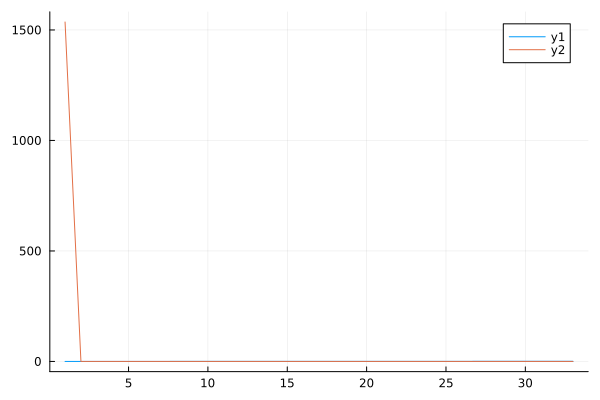

In [48]:
plot(l)

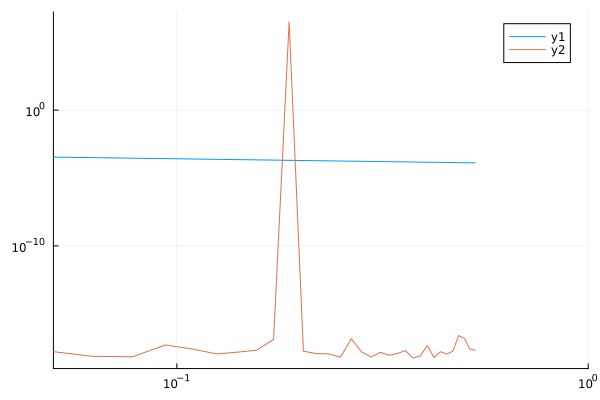

In [57]:
plot(k,k4,yaxis=:log, xaxis=:log,xlims=(10^(-1.3),1^(-0.8)))
#plot!(ps0a[:,1],ps0a[:,2])
#plot!(l[:,1],l[:,2])
plot!(ll[:,1],ll[:,2])